<a href="https://colab.research.google.com/github/Mansouraran/AI-projects/blob/main/project_TimeSeries_Analys.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TimeSeries Analysis
Temperature Forecasting Example

In [ ]:
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import callbacks

## 1- Load and Prepare Data

In [ ]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2025-01-28 01:47:47--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.106.110, 54.231.164.72, 54.231.129.152, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.106.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  --.-KB/s    in 0.05s   

2025-01-28 01:47:48 (241 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [ ]:
df = pd.read_csv('jena_climate_2009_2016.csv')

In [ ]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [ ]:
df.shape

(420451, 15)

In [ ]:
df.drop(columns='Date Time', inplace=True)

In [ ]:
temperature = df['T (degC)']
raw_data = df

<Axes: >

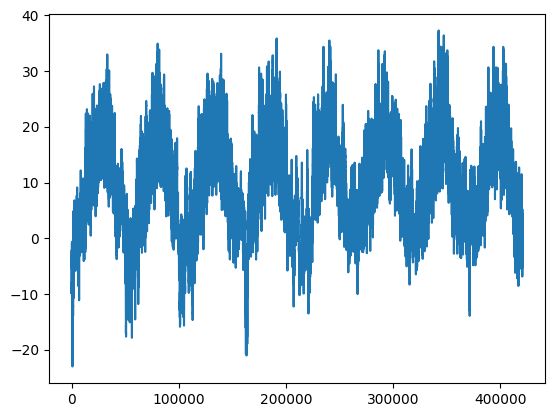

In [ ]:
temperature.plot()

<Axes: >

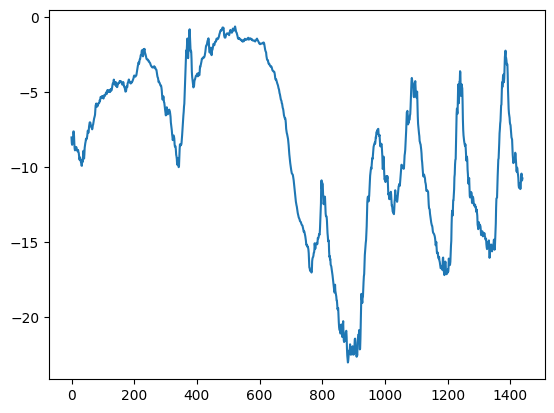

In [ ]:
temperature[:1440].plot()

In [ ]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples

## 2- Normalization

In [ ]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

## 3- Create Train/Val/Test Datasets

In [ ]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

In [ ]:
type(train_dataset)

tensorflow.python.data.ops.batch_op._BatchDataset

In [ ]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


## 3- Reference Baseline

In [ ]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

<ipython-input-15-4673f9f3e87c>:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  preds = samples[:, -1, 1] * std[1] + mean[1]


Validation MAE: 2.44
Test MAE: 2.62


## 5- Models

### 5-1. MLP Model

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GlobalAveragePooling1D()(inputs)  # Safer than Flatten
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras", save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# Ensure dataset shapes are correct before training
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")


Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 48s 57ms/step - loss: 86.8829 - mae: 7.4085 - val_loss: 22.0437 - val_mae: 3.6989
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 83s 58ms/step - loss: 22.7271 - mae: 3.8217 - val_loss: 20.4294 - val_mae: 3.5772
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 47s 57ms/step - loss: 21.8801 - mae: 3.7433 - val_loss: 20.4513 - val_mae: 3.5690
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 48s 58ms/step - loss: 21.6242 - mae: 3.7192 - val_loss: 20.6366 - val_mae: 3.5889
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 48s 59ms/step - loss: 21.4608 - mae: 3.7045 - val_loss: 20.5465 - val_mae: 3.5751
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 54s 65ms/step - loss: 21.3388 - mae: 3.6929 - val_loss: 20.6933 - val_mae: 3.5914
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 46s 56ms/step - loss: 21.2517 - mae: 3.6857 - val_loss: 20.4292 - val_mae: 3.5681
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 48s 58ms/step - loss: 21.1989 - mae: 3.6806 - val_loss: 20.4608 - val_mae: 3.5751
Epoch 9/10
819/819 ━━━━━

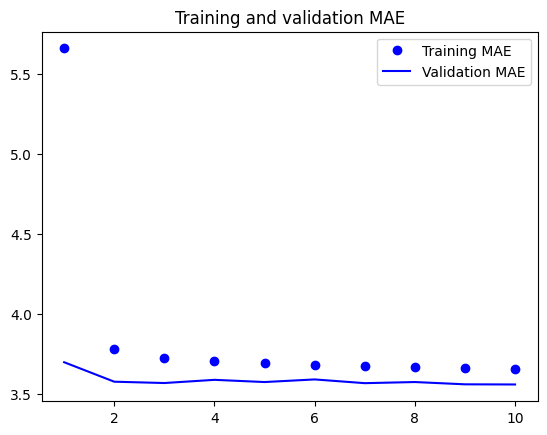

In [ ]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### 5-2. Conv Model

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.h5",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.h5")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 55s 59ms/step - loss: 21.9433 - mae: 3.6874 - val_loss: 16.2180 - val_mae: 3.2004
Epoch 2/10
819/819 [==============================] - 47s 57ms/step - loss: 15.8993 - mae: 3.1837 - val_loss: 15.5946 - val_mae: 3.1492
Epoch 3/10
819/819 [==============================] - 48s 59ms/step - loss: 14.7539 - mae: 3.0585 - val_loss: 16.3307 - val_mae: 3.2205
Epoch 4/10
819/819 [==============================] - 49s 59ms/step - loss: 13.9472 - mae: 2.9687 - val_loss: 14.8443 - val_mae: 3.0510
Epoch 5/10
819/819 [==============================] - 47s 57ms/step - loss: 13.3330 - mae: 2.8978 - val_loss: 14.9000 - val_mae: 3.0530
Epoch 6/10
819/819 [==============================] - 55s 67ms/step - loss: 12.8045 - mae: 2.8378 - val_loss: 15.0010 - val_mae: 3.0316
Epoch 7/10
819/819 [==============================] - 49s 60ms/step - loss: 12.3911 - mae: 2.7916 - val_loss: 13.8977 - val_mae: 2.9206
Epoch 8/10
819/819 [============================

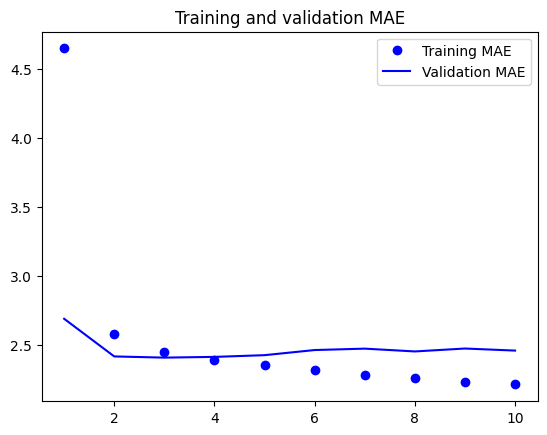

In [ ]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### 5-3. Simple LSTM-based Model

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 103s 123ms/step - loss: 72.3636 - mae: 6.4731 - val_loss: 12.4080 - val_mae: 2.6886
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 100s 122ms/step - loss: 11.8337 - mae: 2.6632 - val_loss: 9.6993 - val_mae: 2.4153
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 101s 123ms/step - loss: 9.9279 - mae: 2.4682 - val_loss: 9.6412 - val_mae: 2.4066
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 100s 122ms/step - loss: 9.4273 - mae: 2.4066 - val_loss: 9.7289 - val_mae: 2.4119
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 102s 124ms/step - loss: 9.1174 - mae: 2.3607 - val_loss: 9.8141 - val_mae: 2.4244
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 142s 124ms/step - loss: 8.8907 - mae: 2.3270 - val_loss: 10.1300 - val_mae: 2.4616
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 99s 120ms/step - loss: 8.6603 - mae: 2.2928 - val_loss: 10.1422 - val_mae: 2.4718
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 141s 119ms/step - loss: 8.5083 - mae: 2.2683 - val_loss: 10.0135 - val_mae: 2.4515
Epoch 9/10
819/819 

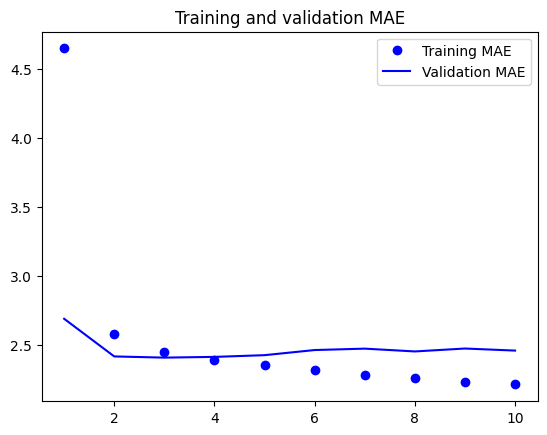

In [ ]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### 5-4. LSTM-based Model + Dropout

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 132s 158ms/step - loss: 49.4334 - mae: 5.2202 - val_loss: 9.5153 - val_mae: 2.4020
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 155s 175ms/step - loss: 15.2234 - mae: 3.0350 - val_loss: 9.1022 - val_mae: 2.3464
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 129s 157ms/step - loss: 14.4994 - mae: 2.9574 - val_loss: 9.1023 - val_mae: 2.3421
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 129s 158ms/step - loss: 13.8960 - mae: 2.8909 - val_loss: 9.1227 - val_mae: 2.3353
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 129s 157ms/step - loss: 13.4237 - mae: 2.8503 - val_loss: 9.0162 - val_mae: 2.3232
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 130s 158ms/step - loss: 13.1943 - mae: 2.8223 - val_loss: 8.8613 - val_mae: 2.3004
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 142s 158ms/step - loss: 12.9925 - mae: 2.7990 - val_loss: 8.8852 - val_mae: 2.3069
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 129s 157ms/step - loss: 12.7093 - mae: 2.7670 - val_loss: 8.9029 - val_mae: 2.3072
Epoch 9/10
819/8

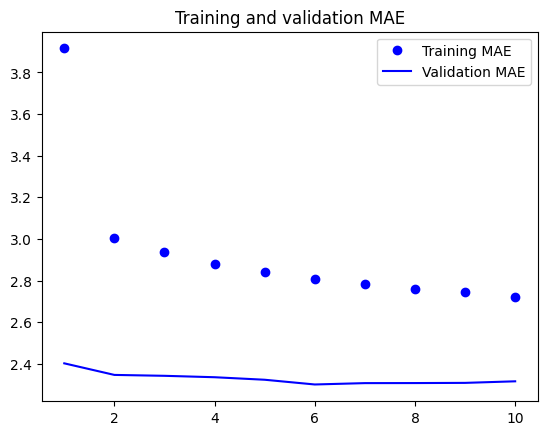

In [ ]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### 5-5. Training and evaluating a dropout-regularized, stacked GRU model

In [ ]:
from tensorflow.keras import layers, models, callbacks, optimizers

# Model Definition
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.2, return_sequences=True)(inputs)  # Reduced dropout
x = layers.GRU(32, recurrent_dropout=0.2)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)  # Default linear activation
model = models.Model(inputs, outputs)

# Custom callback for debugging
class DebugCallback(callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch+1}: loss={logs['loss']}, mae={logs['mae']}, val_loss={logs['val_loss']}, val_mae={logs['val_mae']}")

# Callbacks
callbacks = [
    callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras", save_best_only=True),
    callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    DebugCallback()
]

# Compile with gradient clipping
optimizer = optimizers.RMSprop(clipvalue=1.0)
model.compile(optimizer=optimizer, loss="mse", metrics=["mae"])

# Train
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks
)

# Load best model and evaluate
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")


Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - loss: 65536893084762112.0000 - mae: 10404559.0000Epoch 1: loss=9789124894523392.0, mae=1912997.25, val_loss=96.3091812133789, val_mae=7.910130977630615
819/819 ━━━━━━━━━━━━━━━━━━━━ 266s 320ms/step - loss: 65468908047433728.0000 - mae: 10394203.0000 - val_loss: 96.3092 - val_mae: 7.9101
Epoch 2/10
525/819 ━━━━━━━━━━━━━━━━━━━━ 1:18 268ms/step - loss: 189645572800512.0000 - mae: 185436.7344

KeyboardInterrupt: 

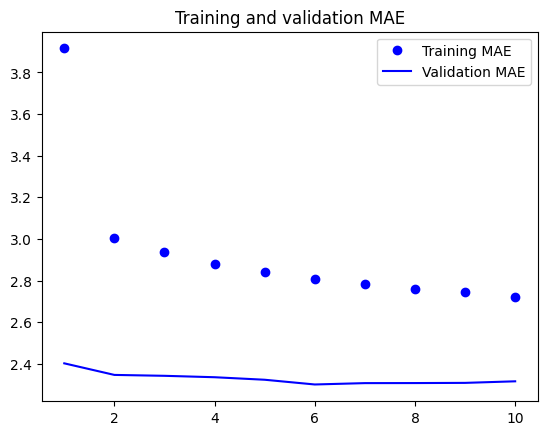

In [ ]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()